In [45]:
from numpy.random import seed
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_curve,auc,accuracy_score
from keras import Sequential
from keras.layers import Embedding,LSTM,Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings('ignore')

> Load the data

In [49]:
Movie_df=pd.read_csv('IMDB Dataset.csv')
print('Shape of dataset::',Movie_df.shape)
Movie_df.head(10)

Shape of dataset:: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


Stats of our data

In [50]:
print("General stats::")
print(Movie_df.info())
print("Summary stats::\n")
print(Movie_df.describe())

General stats::
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None
Summary stats::

                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000


> Number of poitive & negative reviews

In [51]:
Movie_df.sentiment.value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [52]:
reviews=Movie_df['review']
sentiment=Movie_df['sentiment']

In [53]:
print('Classes:',np.unique(sentiment))

Classes: ['negative' 'positive']


In [54]:
Movie_df.isnull().sum()

review       0
sentiment    0
dtype: int64

> Split the data into train & test datasets

In [55]:
train_reviews=reviews[:3000]
train_sentiment=sentiment[:3000]
test_reviews=reviews[3000:]
test_sentiment=sentiment[3000:]
#Shape of train & test dataset
print('Shape of train dataset::',train_reviews.shape,train_sentiment.shape)
print('Shape of test dataset::',test_reviews.shape,test_sentiment.shape)

Shape of train dataset:: (3000,) (3000,)
Shape of test dataset:: (47000,) (47000,)


> Encode our target labels

In [56]:
lb=preprocessing.LabelBinarizer()
#Encode 1 for positive label & 0 for Negative label
train_sentiment=lb.fit_transform(train_sentiment)
test_sentiment=lb.transform(test_sentiment)
#Reshape the array
train_sentiment=train_sentiment.ravel()
test_sentiment=test_sentiment.ravel()
#Convert categoricals to numeric ones
train_sentiment=train_sentiment.astype('int64')
test_sentiment=test_sentiment.astype('int64')



Let's explore our data before normalization

In [57]:
train_reviews[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [58]:
test_reviews[3001]

'I am still trying to figure out what the target of this movie was: 1) Whether to show how stupid, disorganized, unprofessional and arrogant the police is (I surely could add various adjectives here, but I think my point on this is clear). 2) Whether to show how a twisted-minded crook that does not know what he wants from himself can create chaos. 3) Whether to show if a persistent detective will solve a case just by asking the criminal the same stupid question over and over again till the criminal answers? 4) Or was it just to show that any 90 minutes of filmed material can still be called a MOVIE\x85<br /><br />This was one of those movies, that in a way - did not disappoint me. From the first 10 minutes I kind of figured out that this movie will not be nominated for the best movie award, and surprisingly enough \x96 this was consistent throughout the whole time. It was stupid enough to be worth the wait to see how stupidly it will continue and end \x96 and I was not disappointed the

In above paragraphs, we can observe stopwords,html tags,special charcters & numbers, which are not required for sentiment analysis.So we need to remove those by normalizing the review data to reduce dimensionality & noise in the data.

In [59]:
train_sentiment[0:10]

array([1, 1, 1, 0, 1, 1, 1, 0, 0, 1], dtype=int64)

In [60]:
test_sentiment[0:10]

array([0, 0, 1, 0, 1, 1, 1, 0, 0, 1], dtype=int64)

> Data Pre-processing

Let's normalize our data to remove stopwords, html tags and so on.

In [61]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [62]:
ps=PorterStemmer()
stopwords=set(stopwords.words('english'))
# Define function for data mining
def normalize_reviews(review):
    #Excluding html tags
    data_tags=re.sub(r'<[^<>]+>'," ",review)
    #Remove special characters/whitespaces
    data_special=re.sub(r'[^a-zA-Z0-9\s]','',data_tags)
    #converting to lower case
    data_lowercase=data_special.lower()
    #tokenize review data
    data_split=data_lowercase.split()
    #Removing stop words
    meaningful_words=[w for w in data_split if not w in stopwords]
    #Apply stemming
    text= ' '.join([ps.stem(word) for word in meaningful_words])
    return text


> Normalize the train & test data

In [63]:
norm_train_reviews=train_reviews.apply(normalize_reviews)
norm_test_reviews=test_reviews.apply(normalize_reviews)


Let's look at our normalized data

In [64]:
norm_train_reviews[0]

'one review mention watch 1 oz episod youll hook right exactli happen first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use word call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far away would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti surreal couldnt say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom comfort u

In [65]:
norm_test_reviews[3001]

'still tri figur target movi 1 whether show stupid disorgan unprofession arrog polic sure could add variou adject think point clear 2 whether show twistedmind crook know want creat chao 3 whether show persist detect solv case ask crimin stupid question till crimin answer 4 show 90 minut film materi still call movi one movi way disappoint first 10 minut kind figur movi nomin best movi award surprisingli enough consist throughout whole time stupid enough worth wait see stupidli continu end disappoint either complet waist time ye rais question watch throughout well tri fall asleep thought great candid unfortun much coffe'

> Let's create features using bag of words model

In [66]:
cv=CountVectorizer(ngram_range=(1,2))
train_cv=cv.fit_transform(norm_train_reviews)
test_cv =cv.transform(norm_test_reviews)
print('Shape of train_cv::',train_cv.shape)
print('Shape of test_cv::',test_cv.shape)

Shape of train_cv:: (3000, 291498)
Shape of test_cv:: (47000, 291498)


> Let's build our traditional ML models

> Random Forest model

In [67]:
from sklearn.ensemble import RandomForestClassifier

In [68]:
%%time
#Training the classifier
rfc=RandomForestClassifier(n_estimators=20,random_state=42)
rfc=rfc.fit(train_cv,train_sentiment)
score=rfc.score(train_cv,train_sentiment)
print('Accuracy of trained model is ::',score)

Accuracy of trained model is :: 0.999
CPU times: total: 1.77 s
Wall time: 7.45 s


In [69]:
%%time
#Making predicitions
rfc_predict=rfc.predict(test_cv)

CPU times: total: 203 ms
Wall time: 657 ms


<Axes: >

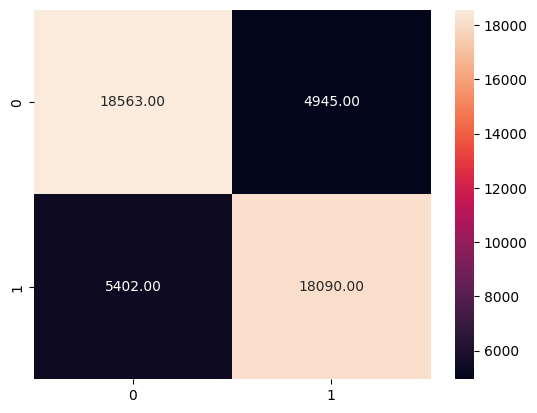

In [70]:
#How accuate our model is?
import seaborn as sns
cm=confusion_matrix(test_sentiment, rfc_predict)
sns.heatmap(cm, fmt=".2f", annot=True)

> 0-Negative class,
> 1-Positive class

In [71]:
#print classification report for performance metrics
cr=classification_report(test_sentiment,rfc_predict)
print('Classification report is::\n',cr)


Classification report is::
               precision    recall  f1-score   support

           0       0.77      0.79      0.78     23508
           1       0.79      0.77      0.78     23492

    accuracy                           0.78     47000
   macro avg       0.78      0.78      0.78     47000
weighted avg       0.78      0.78      0.78     47000




> Recurrent neural network (RNN) with LSTM (Long Short Term Memory) model

In [72]:
#Train dataset
X_train=train_cv
X_train=[str(x[0]) for x in X_train]
y_train=train_sentiment
# Test dataset
X_test=test_cv
X_test=[str(x[0]) for x in X_test]
y_test=test_sentiment


In [73]:
# Tokenize the train & test dataset
Max_Review_length=500
tokenizer=Tokenizer(num_words=Max_Review_length,lower=False)
tokenizer.fit_on_texts(X_train)
#tokenizig train data
X_train_token=tokenizer.texts_to_sequences(X_train)
#tokenizing test data
X_test_token=tokenizer.texts_to_sequences(X_test)

#Truncate or pad the dataset for a length of 500 words for each review
X_train=pad_sequences(X_train_token,maxlen=Max_Review_length)
X_test=pad_sequences(X_test_token,maxlen=Max_Review_length)

In [74]:
print('Shape of X_train datset after padding:',X_train.shape)
print('Shape of X_test dataset after padding:',X_test.shape)

Shape of X_train datset after padding: (3000, 500)
Shape of X_test dataset after padding: (47000, 500)


In [75]:
%%time
# Most poplar words found in the dataset
vocabulary_size=5000
embedding_size=64
model=Sequential()
model.add(Embedding(vocabulary_size,embedding_size,input_length=Max_Review_length))
model.add(LSTM(30))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 64)           320000    
                                                                 
 lstm_1 (LSTM)               (None, 30)                11400     
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 331431 (1.26 MB)
Trainable params: 331431 (1.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
CPU times: total: 31.2 ms
Wall time: 259 ms


In [76]:
#Complile our model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [77]:
%%time
#Train our model
batch_size=128
num_epochs=6
X_valid,y_valid=X_train[:batch_size],train_sentiment[:batch_size]
X_train1,y_train1=X_train[batch_size:],train_sentiment[batch_size:]
# Fit the model
model.fit(X_train1,y_train1,validation_data=(X_valid,y_valid),validation_split=0.2,
          batch_size=batch_size,epochs=num_epochs, verbose=1,shuffle=True)


Epoch 1/6
23/23 [==============================] - 12s 421ms/step - loss: 0.6937 - accuracy: 0.4861 - val_loss: 0.6962 - val_accuracy: 0.4375
Epoch 2/6
23/23 [==============================] - 8s 318ms/step - loss: 0.6932 - accuracy: 0.5059 - val_loss: 0.6954 - val_accuracy: 0.4375
Epoch 3/6
23/23 [==============================] - 7s 299ms/step - loss: 0.6931 - accuracy: 0.5070 - val_loss: 0.6950 - val_accuracy: 0.4375
Epoch 4/6
23/23 [==============================] - 7s 294ms/step - loss: 0.6932 - accuracy: 0.5070 - val_loss: 0.6953 - val_accuracy: 0.4375
Epoch 5/6
23/23 [==============================] - 7s 303ms/step - loss: 0.6934 - accuracy: 0.4892 - val_loss: 0.6938 - val_accuracy: 0.4297
Epoch 6/6
23/23 [==============================] - 6s 269ms/step - loss: 0.6931 - accuracy: 0.5080 - val_loss: 0.6957 - val_accuracy: 0.4375
CPU times: total: 8.14 s
Wall time: 46.3 s


In [78]:
%%time
# Predictions
y_predict_rnn=model.predict(X_test)
#Changing the shape of y_predict to 1-Dimensional
y_predict_rnn1=y_predict_rnn.ravel()
y_predict_rnn1=(y_predict_rnn1>0.5)
y_predict_rnn1[0:10]

1469/1469 [==============================] - 54s 37ms/step
CPU times: total: 5.72 s
Wall time: 55 s


array([ True,  True,  True,  True, False,  True,  True,  True,  True,
        True])

In [79]:
cm_rnn=confusion_matrix(y_test,y_predict_rnn1)
cm_rnn

array([[ 2605, 20903],
       [ 2807, 20685]], dtype=int64)

In [80]:
#Classification report for performance metrics
cr_rnn=classification_report(y_test,y_predict_rnn1)
print('The Classification report is::\n',cr_rnn)

The Classification report is::
               precision    recall  f1-score   support

           0       0.48      0.11      0.18     23508
           1       0.50      0.88      0.64     23492

    accuracy                           0.50     47000
   macro avg       0.49      0.50      0.41     47000
weighted avg       0.49      0.50      0.41     47000

